<a href="https://colab.research.google.com/github/itailironne/ML-course-final-thesis/blob/master/LoanPrepay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Statistics:
        customer_id           age         income   loan_amount  credit_score  \
count  15904.000000  15904.000000   15904.000000  15904.000000  15904.000000   
mean    5006.795397     43.613745   99107.901723  27395.828219    575.201522   
std     2862.708907     14.946096   29106.098835  12903.049120    160.234209   
min        1.000000     18.000000   50002.000000   5008.000000    300.000000   
25%     2531.750000     31.000000   73431.500000  16555.500000    435.000000   
50%     4972.500000     43.000000   98807.000000  27286.000000    573.000000   
75%     7488.250000     57.000000  124489.000000  38461.750000    713.000000   
max    10000.000000     69.000000  149997.000000  49995.000000    849.000000   

       surfing_time  visited_pages   loan_repaid  monthly_income  \
count  15904.000000   15904.000000  15904.000000    15904.000000   
mean     275.396756      26.833690      0.505470    12442.702905   
std      130.181972      12.978952      0.499986     4340

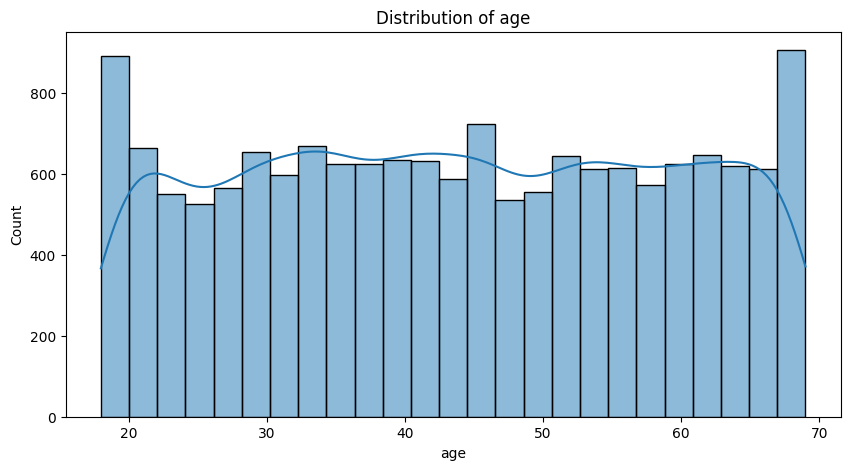

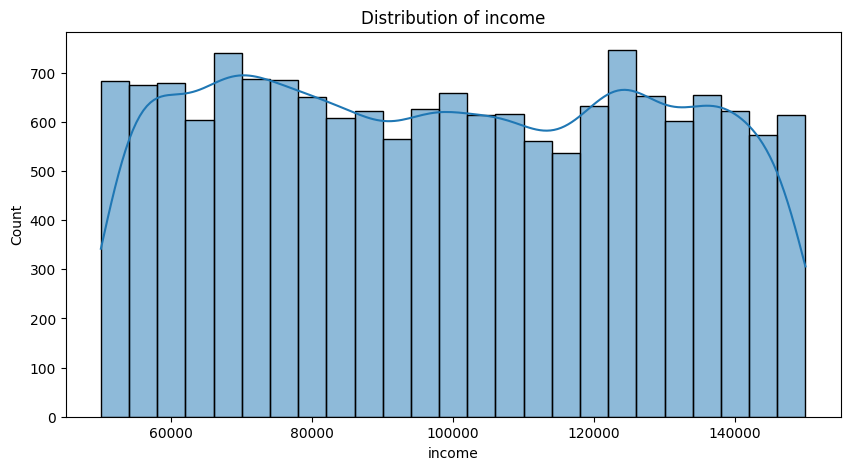

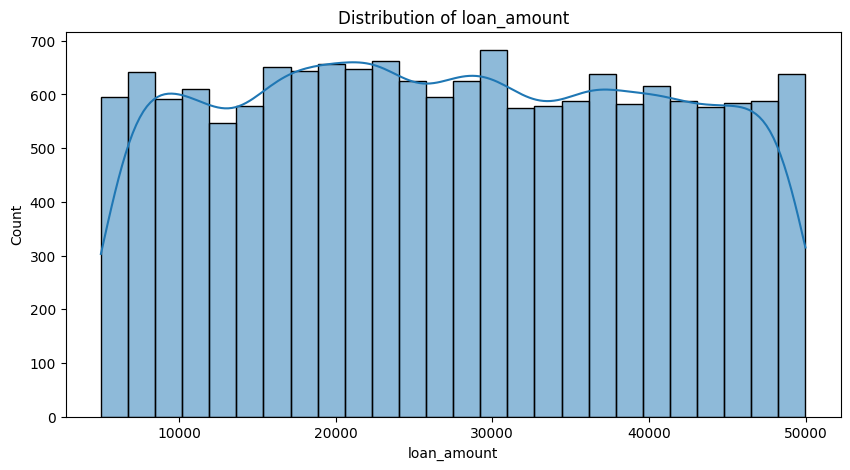

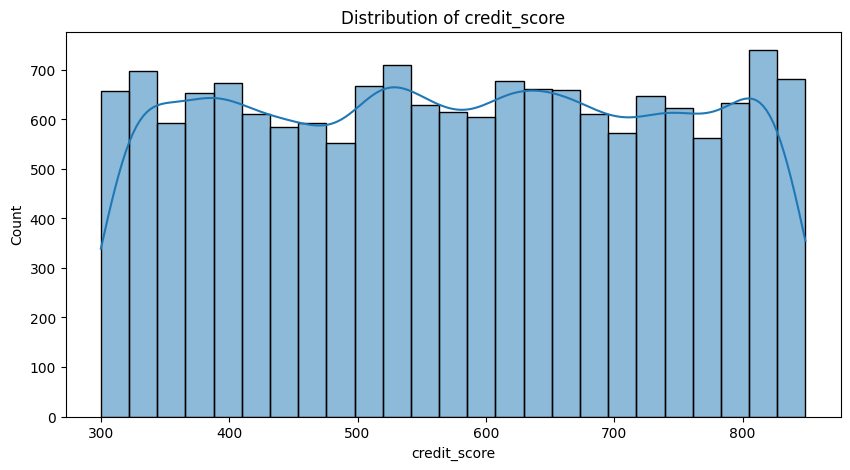

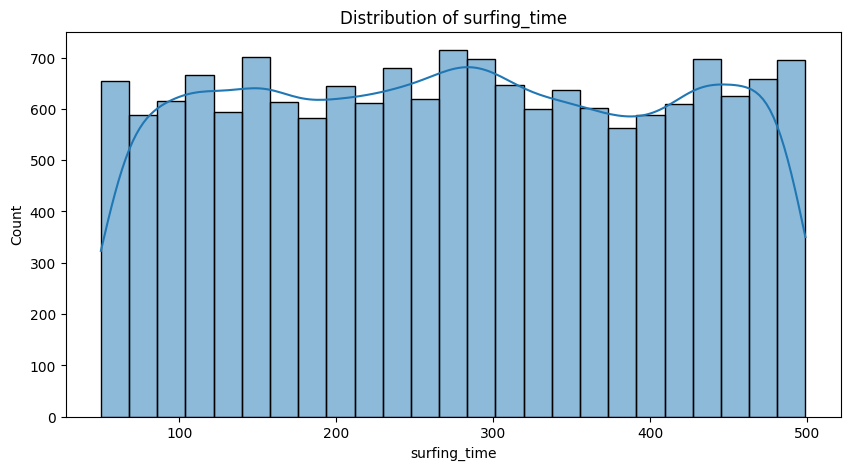

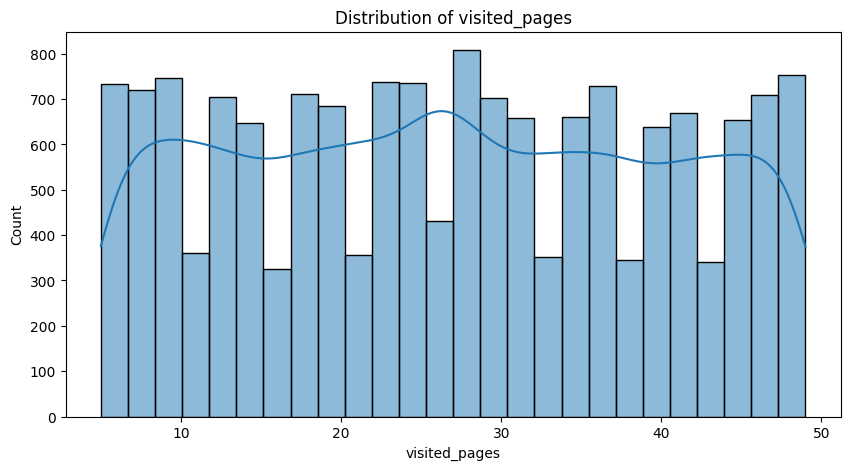

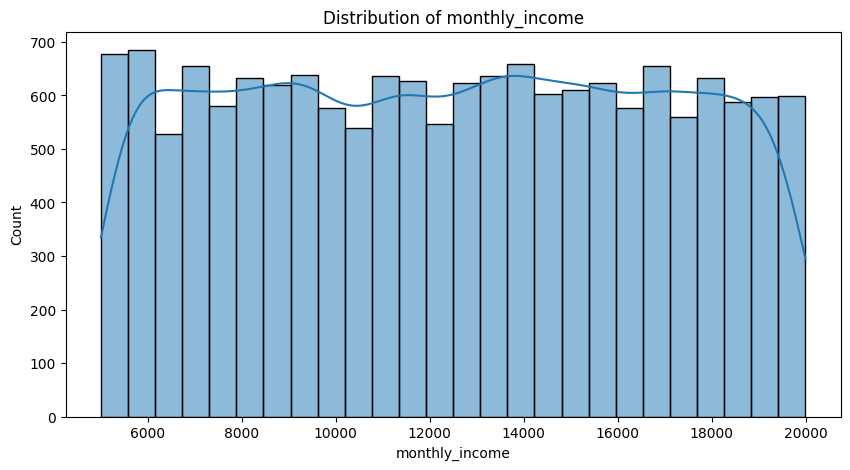

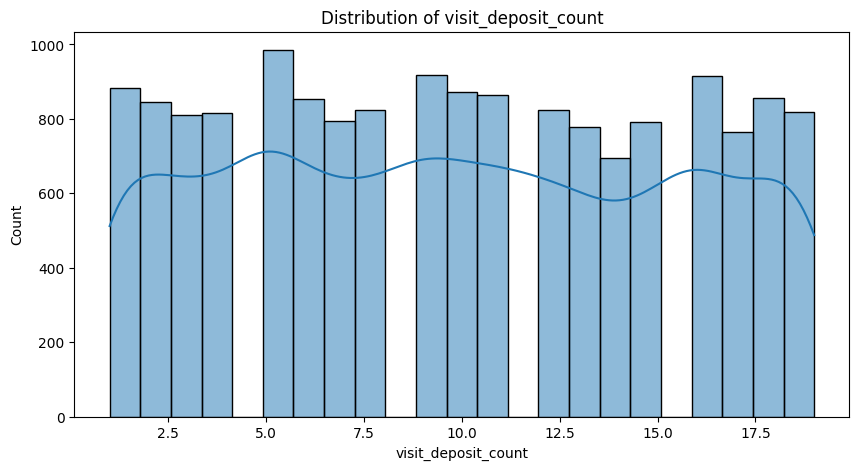

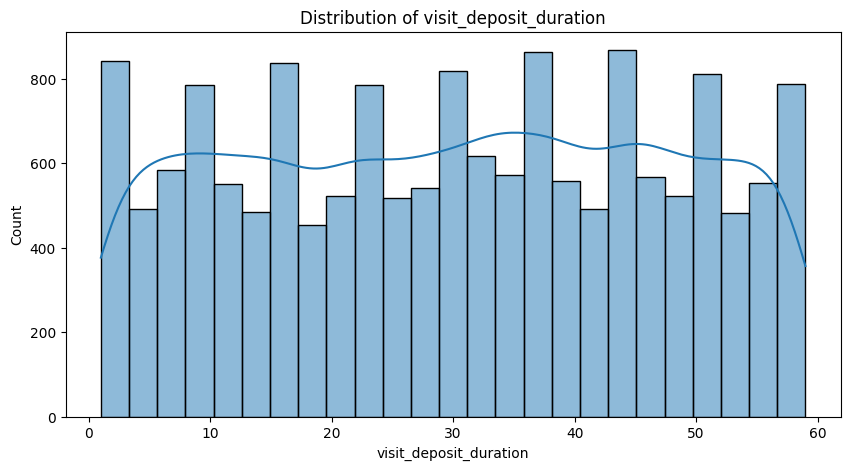

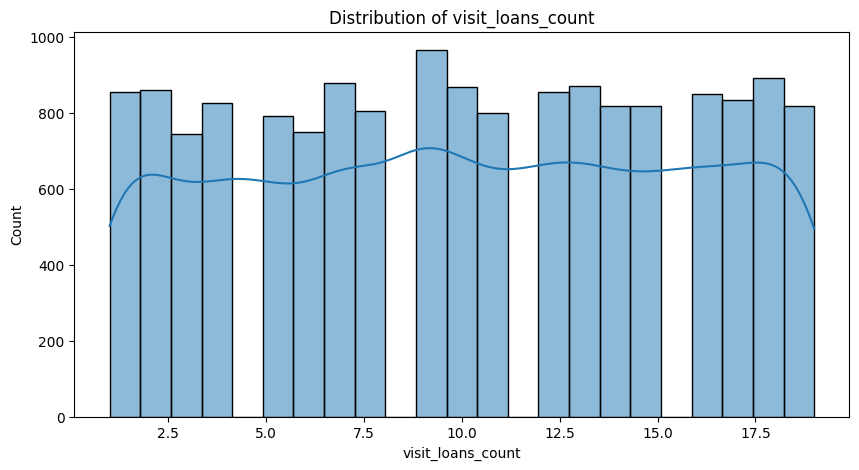

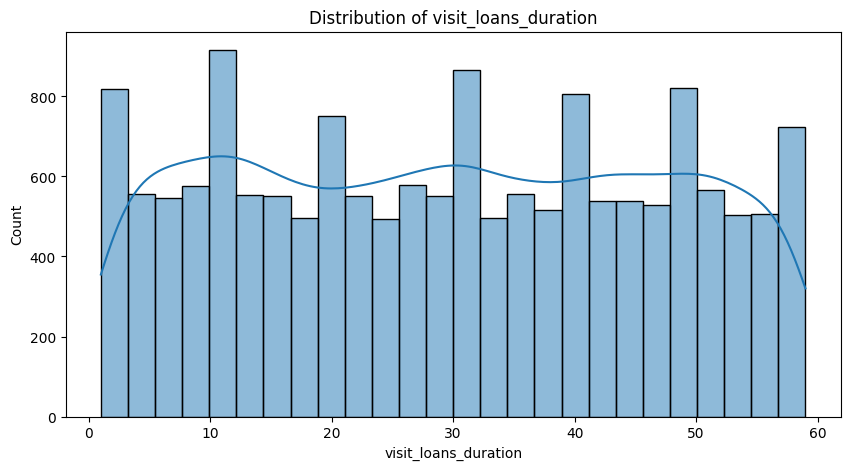

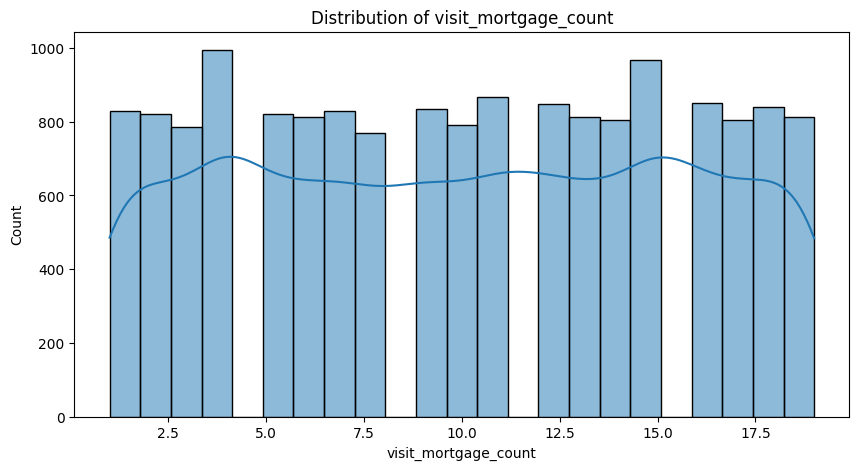

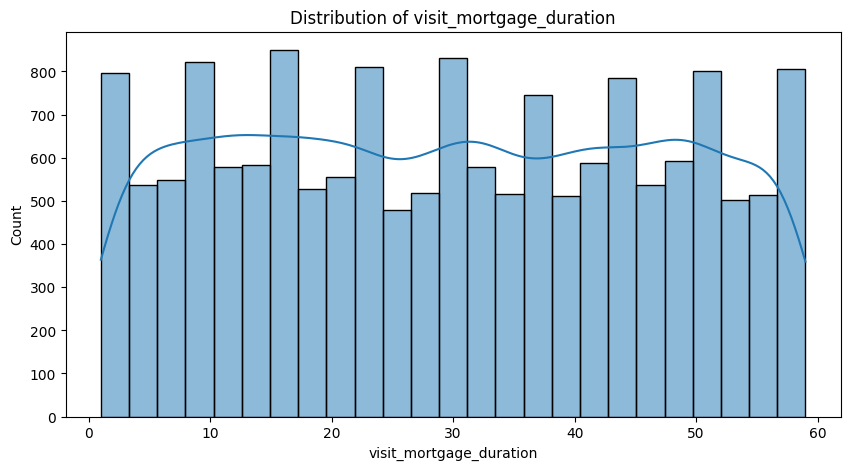

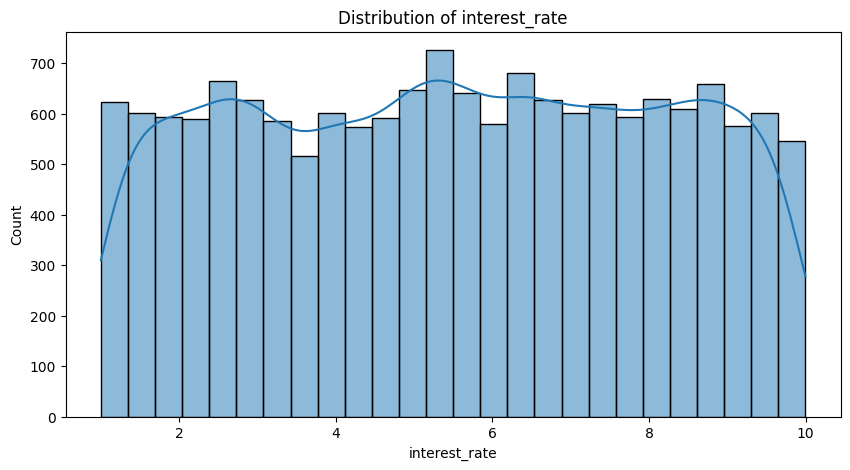

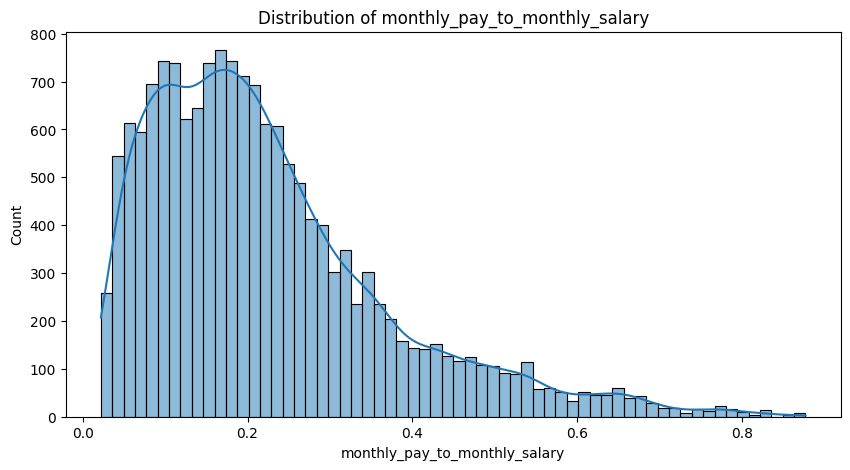

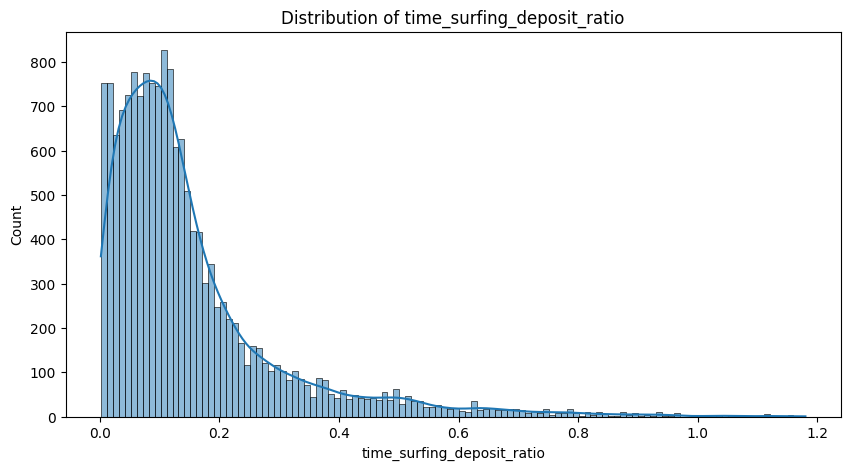

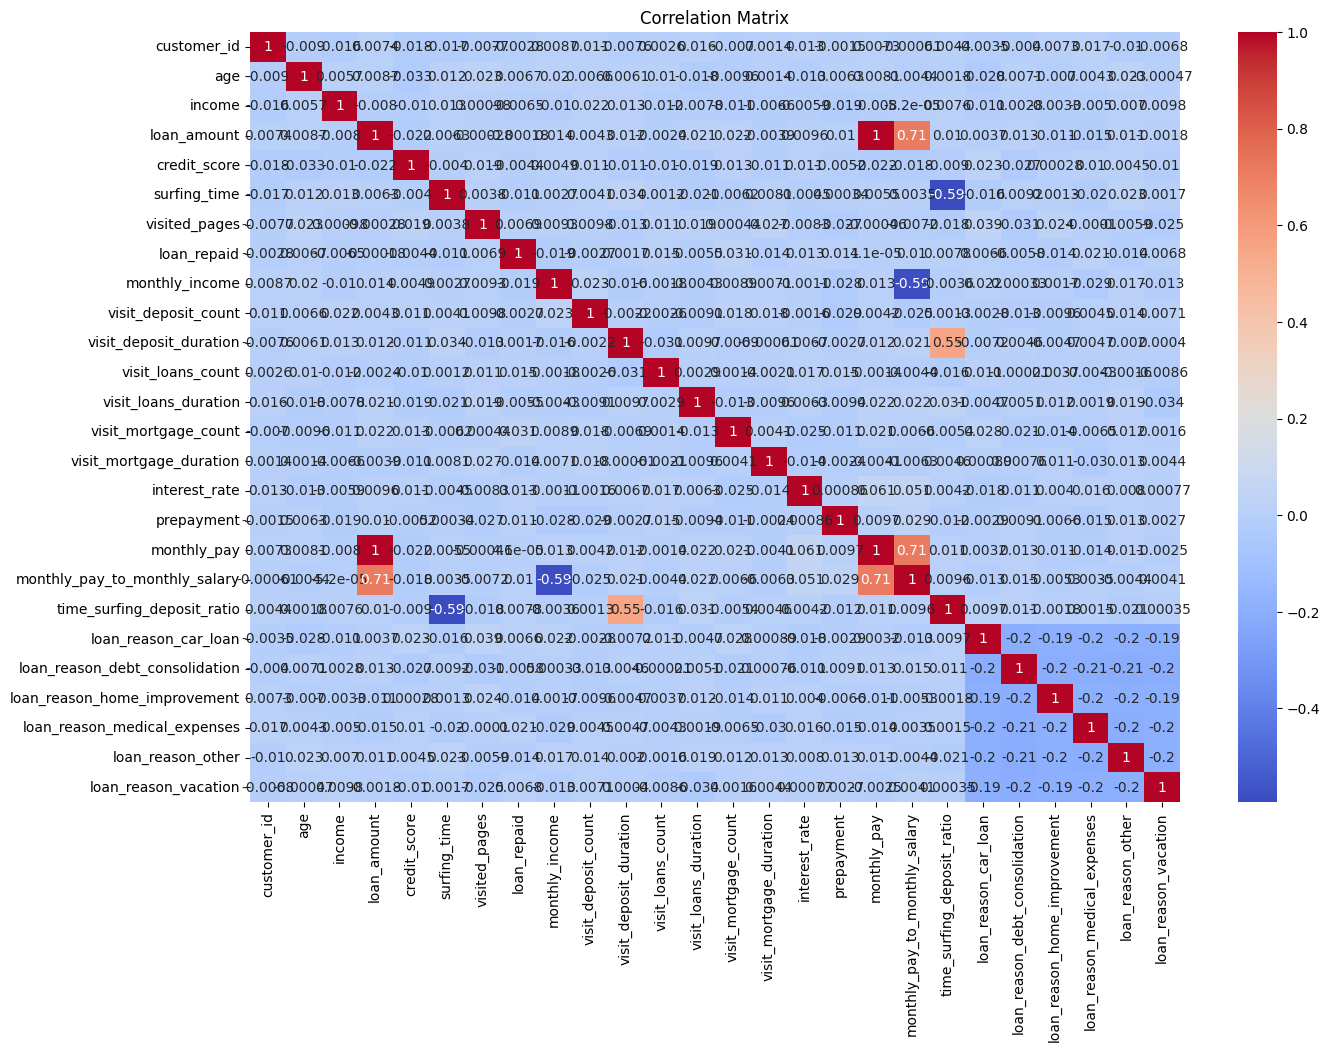

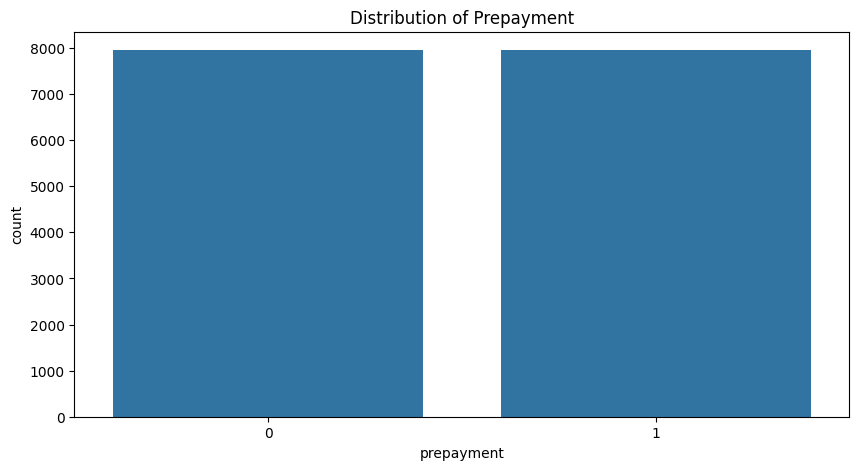

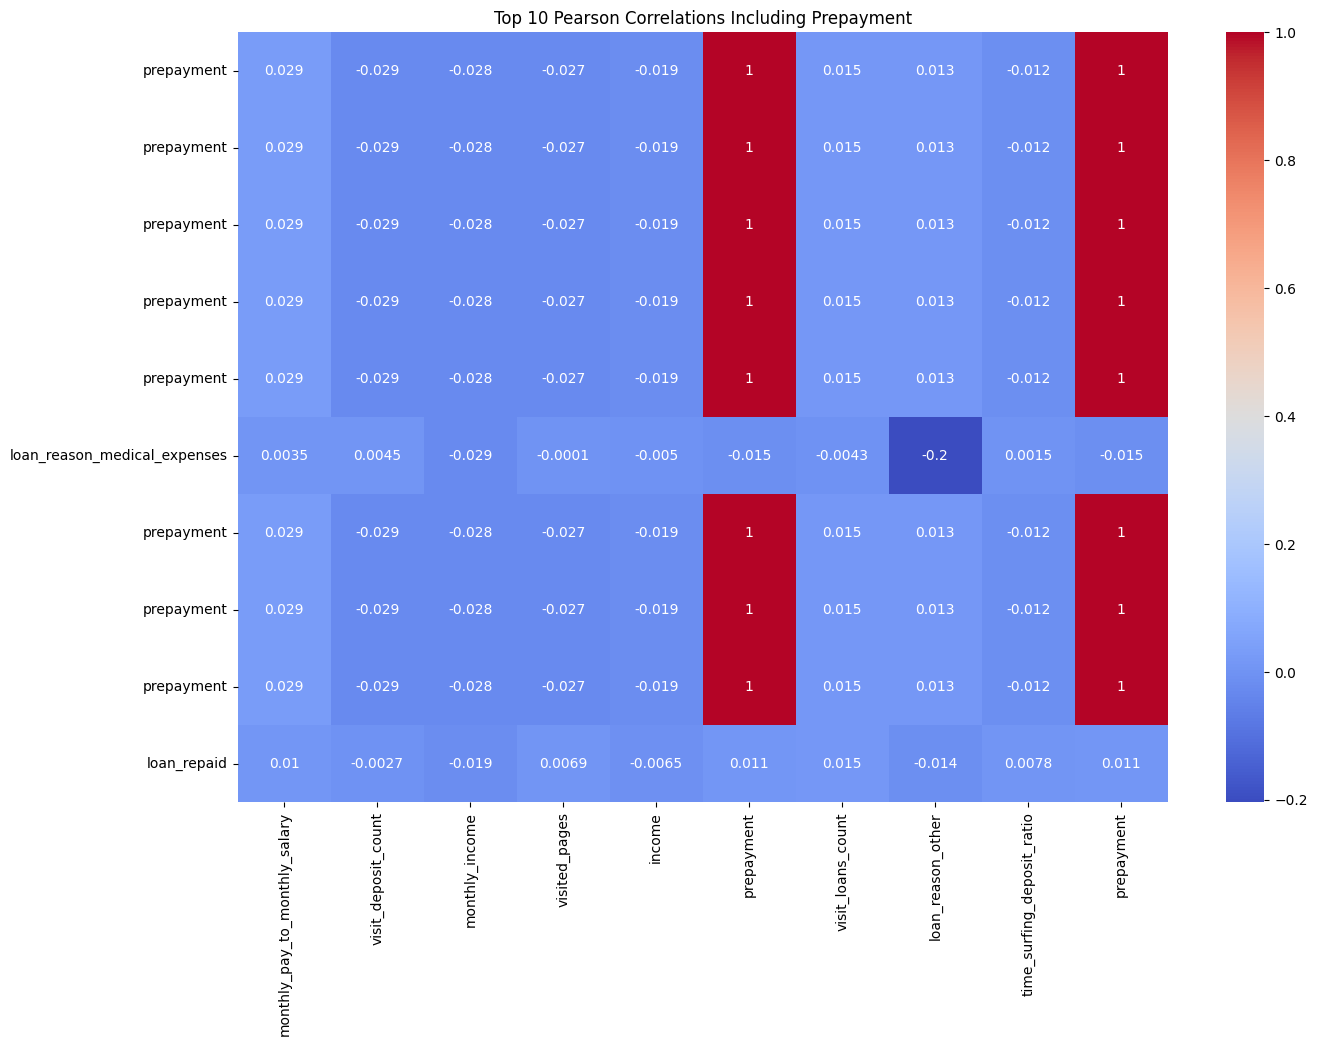

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2376
           1       0.86      0.88      0.87      2396

    accuracy                           0.87      4772
   macro avg       0.87      0.87      0.87      4772
weighted avg       0.87      0.87      0.87      4772

Confusion Matrix:
[[2044  332]
 [ 280 2116]]


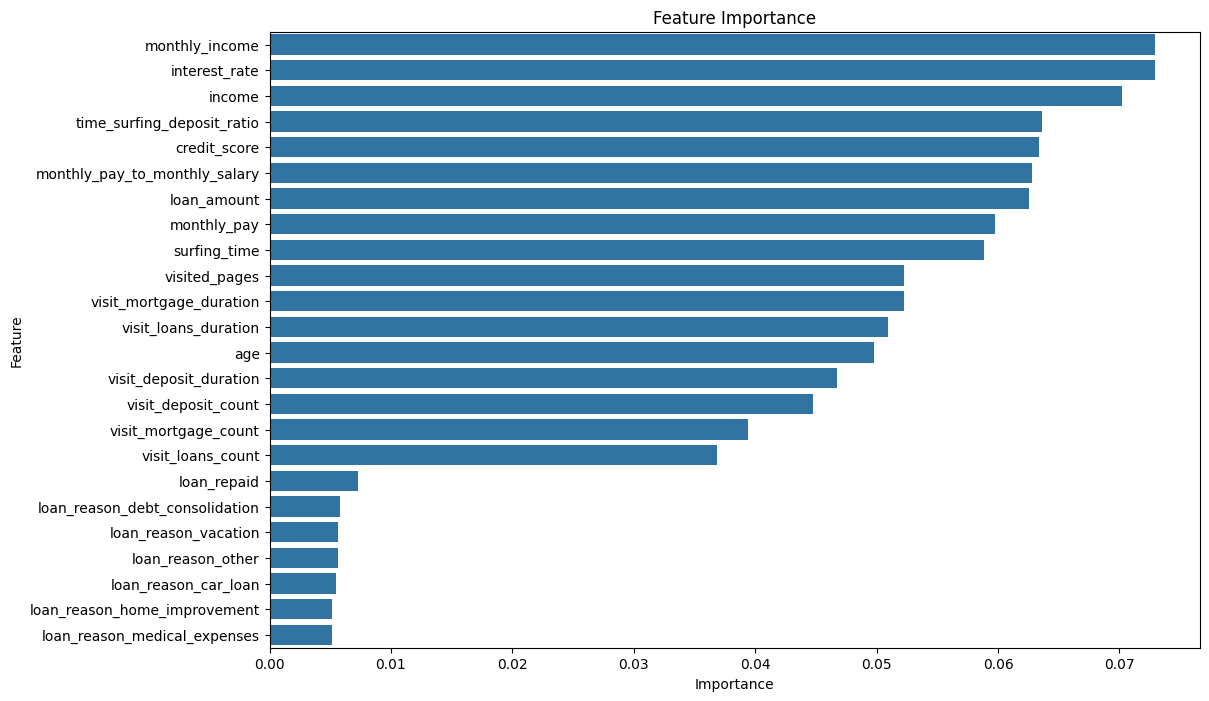

['loan_prepayment_model.pkl']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib

# Set random seed for reproducibility
np.random.seed(42)

# Define number of samples
num_samples = 10000

# Generate synthetic data
loan_reasons = ['debt_consolidation', 'home_improvement', 'car_loan', 'medical_expenses', 'vacation', 'other']

data = {
    'customer_id': np.arange(1, num_samples + 1),
    'age': np.random.randint(18, 70, num_samples),
    'income': np.random.randint(50000, 150000, num_samples),
    'loan_amount': np.random.randint(5000, 50000, num_samples),
    'credit_score': np.random.randint(300, 850, num_samples),
    'surfing_time': np.random.randint(50, 500, num_samples),
    'visited_pages': np.random.randint(5, 50, num_samples),
    'loan_repaid': np.random.randint(0, 2, num_samples),
    'loan_reason': np.random.choice(loan_reasons, num_samples),
    'monthly_income': np.random.randint(5000, 20000, num_samples),
    'visit_deposit_count': np.random.randint(1, 20, num_samples),
    'visit_deposit_duration': np.random.randint(1, 60, num_samples),
    'visit_loans_count': np.random.randint(1, 20, num_samples),
    'visit_loans_duration': np.random.randint(1, 60, num_samples),
    'visit_mortgage_count': np.random.randint(1, 20, num_samples),
    'visit_mortgage_duration': np.random.randint(1, 60, num_samples),
    'interest_rate': np.random.uniform(1.0, 10.0, num_samples),
    'prepayment': np.random.choice([0, 1], num_samples, p=[0.8, 0.2])
}

# Calculate monthly pay assuming a simple interest model with fixed monthly payments
data['monthly_pay'] = data['loan_amount'] * (1 + data['interest_rate'] / 100) / 12

# Calculate the ratio of monthly pay to monthly salary
data['monthly_pay_to_monthly_salary'] = data['monthly_pay'] / data['monthly_income']

# Calculate the ratio of time spent surfing the deposit page to total surfing time
data['time_surfing_deposit_ratio'] = data['visit_deposit_duration'] / data['surfing_time']

# Convert to DataFrame
df = pd.get_dummies(pd.DataFrame(data), columns=['loan_reason'])

# Balance the dataset using oversampling
df_majority = df[df['prepayment'] == 0]
df_minority = df[df['prepayment'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Perform EDA
def perform_eda(df):
    # Display basic statistics
    print("Basic Statistics:")
    print(df.describe())

    # Plot distributions of numerical features
    numerical_features = ['age', 'income', 'loan_amount', 'credit_score', 'surfing_time',
                          'visited_pages', 'monthly_income', 'visit_deposit_count',
                          'visit_deposit_duration', 'visit_loans_count', 'visit_loans_duration',
                          'visit_mortgage_count', 'visit_mortgage_duration', 'interest_rate',
                          'monthly_pay_to_monthly_salary', 'time_surfing_deposit_ratio']

    for feature in numerical_features:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.show()

    # Plot the correlation matrix
    plt.figure(figsize=(15, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Plot distributions of target variable
    plt.figure(figsize=(10, 5))
    sns.countplot(x='prepayment', data=df)
    plt.title('Distribution of Prepayment')
    plt.show()

    # Pearson Correlation
    pearson_corr = df.corr(method='pearson')
    # Ensure 'prepayment' is always included in the top correlations
    pearson_corr_abs = pearson_corr.abs().unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
    top_10_corr = [index for index in pearson_corr_abs.index if 'prepayment' in index][:10]  # get top 10 correlations including 'prepayment'

    plt.figure(figsize=(15, 10))
    sns.heatmap(pearson_corr.loc[[i[0] for i in top_10_corr], [i[1] for i in top_10_corr]], annot=True, cmap='coolwarm')
    plt.title('Top 10 Pearson Correlations Including Prepayment')
    plt.show()

perform_eda(df_balanced)

# Split the data into training and testing sets
X = df_balanced.drop(['customer_id', 'prepayment'], axis=1)
y = df_balanced['prepayment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Save the trained model to a file
joblib.dump(model, 'loan_prepayment_model.pkl')

